* IRIS (회귀)
- 피쳐: 3개	Sepal Length, Sepal Width, Petal  Length
- 타겟: 1개 Petal Width

* IRIS (2진 분류)
- 피쳐: 4개
- 타겟: 1개
- Class: 품종 2개만 선택 <- (Setosa & 나머지) => 불균형 데이터 (50 & 100)

* IRIS (다중 분류)
- 피쳐: 4개
- 타겟: 1개
- Class: 품종 3개
<hr>
* MNIST-DIGIT
- 피쳐: 64개
- 타겟: 1개
- Class: 0~9 10개, 

* MNIST-fashion

### DNN 기반 회귀 모델 구현
- 데이터셋: iris.csv
- 피쳐: 3개 Sepal Length, Sepal Width, Petal Length, Petal  Width
- 타겟: 1개 Setosa Versicolor Verginica
- 학습방법: 지도학습 >> 분류
- 알고리즘: 인공신경망(ANN), MLP, 심층신경망(DNN)
- 프레임워크: Pytorch

#### [1] 모듈 로딩 & 데이터 준비


In [1]:
# 모듈 관련
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

from torchmetrics.classification import MulticlassF1Score
from torchinfo import summary

# DF 로드 및 시각화 모듈
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 전처리용 모듈
from sklearn.preprocessing import *
from sklearn.model_selection import train_test_split

In [2]:
# 모듈 버전 확인				=> 사용자 정의 함수로 구현하기!!
print(f'torch v.{torch.__version__}')
print(f'pandas v.{pd.__version__}')

torch v.2.4.1
pandas v.2.0.3


In [3]:
# 데이터 로딩
DATA_FILE = DATA_FILE = r'C:\Users\KDP-43\Desktop\머신러닝_1\data\iris.csv'

irisDF = pd.read_csv(DATA_FILE, usecols=[0,1,2,3,4])
irisDF.head(3)

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa


In [4]:
labels = dict(zip(irisDF['variety'].unique().tolist(), range(3)))

irisDF['variety'] = irisDF['variety'].replace(labels)
irisDF.head(3)

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0


#### [2] 모델 클래스 설계 및 정의
- 클래스 목적:	iris 데이터 학습 및 예측(추론)
- 클래스 이름:	IrisMCFModel
- 부모클래스 :	nn.Module
- 매개 변수	 : 층별 입출력 개수 고정하기에 필요 X
- 속성/필드  :	
- 기능/역할  :	__init__(): 모델 구조, forward(): 순방향 학습 <= 오버라이딩!!
- 클래스구조
	* 입력층: 입력 4개(피쳐)	출력 10개 	-> 퍼셉트론/뉴런 10개 존재
	* 은닉층: 입력 10개			출력 5개   -> 퍼셉트론/뉴런 5개 존재
	* 출력층: 입력 5개				출력 3개 (다중 분류)
<br>
- 손실함수/활성화함수
	* 클래스 형태	==> nn.MSELoss, nn.ReLU	   ==> \___init___ 메서드
	* 함수 형태 ==> torch.nn.fucntional 아래에 ==> forward() 메서드

In [5]:
class IrisMCFModel( nn.Module):
    
	# 모델 인스턴스 생성 메서드
	def __init__(self):
		super().__init__()

		self.in_layer = nn.Linear(4, 10)
		self.hidden_layer = nn.Linear(10, 5)
		self.out_layer = nn.Linear(5, 3)

	# 순방향 학습 진행 메서드
	def forward(self, input_data):
		# 입력층
		y = F.relu( self.in_layer(input_data) )		

		# 은닉층: 10개의 숫자 값 (>=0)
		y = F.relu( self.hidden_layer(y))			

		# 출력층: 5개의 숫자 값 (>=0)
		return self.out_layer(y)					# 다중분류 => 손실함수 crossEntropyLoss가 내부에서 softmax 진행행


In [6]:
# 모델 인스턴스 생성
model = IrisMCFModel()

print(model)
print()
summary(model, input_size=(10000,4))				# 실제 학습할 데이터 크기 할당량 체크!

IrisMCFModel(
  (in_layer): Linear(in_features=4, out_features=10, bias=True)
  (hidden_layer): Linear(in_features=10, out_features=5, bias=True)
  (out_layer): Linear(in_features=5, out_features=3, bias=True)
)



Layer (type:depth-idx)                   Output Shape              Param #
IrisMCFModel                             [10000, 3]                --
├─Linear: 1-1                            [10000, 10]               50
├─Linear: 1-2                            [10000, 5]                55
├─Linear: 1-3                            [10000, 3]                18
Total params: 123
Trainable params: 123
Non-trainable params: 0
Total mult-adds (M): 1.23
Input size (MB): 0.16
Forward/backward pass size (MB): 1.44
Params size (MB): 0.00
Estimated Total Size (MB): 1.60

#### [3] 데이터셋 클래스 설계 및 정의 <hr>
- 데이터셋: iris.csv
- 피쳐_개수: 4개
- 타겟_개수: 3개
- 클래스 이름: IrisDataset
- 부모클래스: utils.data.Dataset
- 속성_필드: featureDF, targetDF, n_rows, n_features
- 필수 메서드:
	* _ \___init_ _(self): 데이터 저장 및 전처리, 개발자가 필요한 속성 설정
	* _ _len_ _(self): 데이터 개수 반환
	* _ _getitem_ _(self, idx): 특정 인덱스의 피쳐 타겟 반환

In [7]:
class IrisDataset(Dataset):
    
	def __init__(self, featureDF, targetDF):
		self.featureDF = featureDF
		self.targetDF = targetDF
		self.n_rows = featureDF.shape[0]
		self.n_features = featureDF.shape[1]

	def __len__(self):
		return self.n_rows

	def __getitem__(self,idx):

		# 텐서화
		featureTS = torch.FloatTensor( self.featureDF.iloc[idx].values)
		targetTS = torch.FloatTensor( self.targetDF.iloc[idx].values)


		return featureTS, targetTS

In [8]:
# [테스트] 데이터셋 인스턴스 생성

featureDF = irisDF[irisDF.columns[:-1]]
targetDF = irisDF[irisDF.columns[-1:]]

# 커스텀 데이터셋 인스턴스 생성
irisDS = IrisDataset(featureDF, targetDF)

# 데이터로더 인스턴스 생성
irisDL = DataLoader(irisDS)

for feature, label in irisDL:
    print(feature.shape, label.shape, feature, label)
    break

torch.Size([1, 4]) torch.Size([1, 1]) tensor([[5.1000, 3.5000, 1.4000, 0.2000]]) tensor([[0.]])


#### [4] 학습 준비 <hr>
- 학습 횟수: EPOCH			<- 처음 ~ 끝까지 공부하는 단위
- 배치 크기: BATCH_SIZE		<- 한 번에 학습할 데이터셋 양
- 위치 지정: DEVICE			<- 텐서 저장 및 실행 위치 (GPU/CPU)
- 학습률(lr): 가중치 & 절편 업데이트 시 경사하강법 이동(업데이트) 간격 설정 0.0001~0.1

In [9]:
### 학습 진행 관련 설정
EPOCH = 100
BATCH_SIZE = 10
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
LR = 0.001

- 인스턴스/객체: 모델, 데이터셋, 최적화(손실함수, 성능지표)

In [10]:
# 모델 인스턴스
model = IrisMCFModel()

# DS & DL 인스턴스
# - 학습용, 검증용, 테스트용 데이터 분리터 분리
X_train, X_test, y_train, y_test = train_test_split(featureDF, targetDF, random_state=10)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=10)

print(f'{X_train.shape} {X_test.shape} {X_val.shape}')
print(f'{y_train.shape} {y_test.shape} {y_val.shape}')
print(f'{type(X_train)} {type(X_test)} {type(X_val)}')


trainDS = IrisDataset(X_train, y_train)
testDS = IrisDataset(X_test, y_test)
valDS = IrisDataset(X_val, y_val)

# 데이터로더 인스턴스
trainDL = DataLoader(trainDS, batch_size = BATCH_SIZE)
# trainDL = DataLoader(trainDS, batch_size = BATCH_SIZE, drop_last=True)	# 나머지는 버려려

(84, 4) (38, 4) (28, 4)
(84, 1) (38, 1) (28, 1)
<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'>


- 최적화, 손실함수, 성능지표 

In [11]:
# 최적화 인스턴스 => Weight, bias 텐서 w.m, model.parameters() 전달
optimizer = optim.Adam(model.parameters(), lr=LR)

# 손실함수 인스턴스 => 다중분류 -> CrossEntropyLoss
# 					=> 예측값은 선형식 결과 값 전달 ==> sigmoid() AF 처리 X
crossLoss = nn.CrossEntropyLoss()

#### [5] 학습 진행

In [12]:
## 학습 효과 확인 손실값과 성능평가값 저장 필요

LOSS_history  = {'Train':[], 'Val':[] }
SCORE_history = {'Train':[], 'Val':[] }

BATCH_CNT = len(trainDL)				# trainDS.n_rows/BATCH_SIZE

for epoch in range(EPOCH):
    
	
	# 학습 모드로 모델 설정
    model.train()
    
    loss_total=0
    score_total =0

	# 배치크기만큼 데이터 로딩 & 학습 진행
    for featureTS, targetTS in trainDL:
        
		# 1 epoch 학습
        pre_y = model(featureTS)
        
		# 손실계산
        loss = crossLoss(pre_y, targetTS.reshape(-1).long())		# long() 
        															# 	-> crossLoss(): scalar(0D) or 1D 데이터만 & long 타입만!
        loss_total += loss.item()
        
		# 성능평가 계산
        score = MulticlassF1Score(num_classes=3)(pre_y, targetTS.reshape(-1))
        score_total += score.item()
        
		# 최적화 진행
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
	# 한 에포크에 대해 검증
    # 모델 -> 검증 모드로 설정
    model.eval()
    
    with torch.no_grad():			# required_grade= True 로 설정된 파라미터 해제!!
        # 검증 데이터셋
        val_featureTS = torch.FloatTensor( valDS.featureDF.values )
        val_targetTS = torch.FloatTensor( valDS.targetDF.values )
        
		# 평가
        pre_val = model(val_featureTS)
        
		# 손실
        loss_val = crossLoss(pre_val, val_targetTS.reshape(-1).long())
        # 성능평가
        score_val = MulticlassF1Score(num_classes=3)(pre_val, val_targetTS.reshape(-1))
        
	# 한 에포크 당 손실값과 성능평가값 저장
    LOSS_history['Train'].append(loss_total/BATCH_CNT)
    SCORE_history['Train'].append(score_total/BATCH_CNT)
    
    LOSS_history['Val'].append(loss_val)
    SCORE_history['Val'].append(score_val)
    
    if epoch%50 ==0: 
        print(f"[{epoch}/{EPOCH}]\n- [Train] LOSS: {LOSS_history['Train'][-1]:.5f} Score: {SCORE_history['Train'][-1]:.5f}")
        print(f"- [Valid] LOSS: {LOSS_history['Val'][-1]:.5f} Score: {LOSS_history['Val'][-1]:.5f}")

[0/100]
- [Train] LOSS: 1.29382 Score: 0.15135
- [Valid] LOSS: 1.23221 Score: 1.23221
[50/100]
- [Train] LOSS: 0.59203 Score: 0.58970
- [Valid] LOSS: 0.59900 Score: 0.59900


In [15]:
    # 테스트
    # 모델 -> 검증 모드로 설정
model.eval()
    
loss_test_tot = []
score_test_tot = []

with torch.no_grad():			# required_grade= True 로 설정된 파라미터 해제!!
	# 검증 데이터셋
	test_featureTS = torch.FloatTensor( testDS.featureDF.values )
	test_targetTS = torch.FloatTensor( testDS.targetDF.values )
	
	# 평가
	pre_test = model(test_featureTS)
	
	# 손실
	loss_test = crossLoss(pre_test, test_targetTS.reshape(-1).long())
	
	# 성능평가
	score_test = MulticlassF1Score(num_classes=3)(pre_test, test_targetTS.reshape(-1))

	print("test_loss",loss_test, "test_score", score_test)

test_loss tensor(0.3335) test_score tensor(0.9505)


Text(0.5, 1.0, 'f1-score')

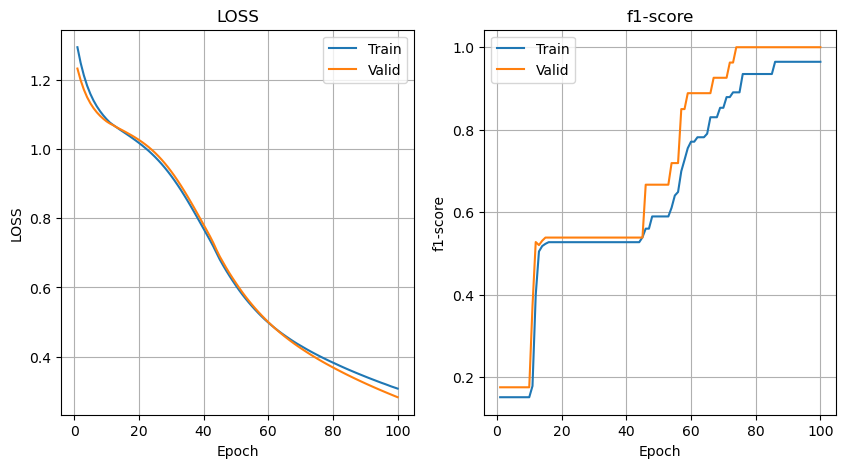

In [13]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1,2, figsize=(10,5))

axes[0].plot(range(1, EPOCH+1), LOSS_history['Train'],label="Train")
axes[0].plot(range(1, EPOCH+1), LOSS_history['Val'],label="Valid")
axes[0].grid()
axes[0].legend()
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("LOSS")
axes[0].set_title("LOSS")

axes[1].plot(range(1, EPOCH+1), SCORE_history['Train'],label="Train")
axes[1].plot(range(1, EPOCH+1), SCORE_history['Val'],label="Valid")
axes[1].grid()
axes[1].legend()
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("f1-score")
axes[1].set_title("f1-score")